# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp cli/pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math

import zarr
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import colorcet

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from dask_cuda import LocalCUDACluster

from decorrelation.pl import emi, ds_temp_coh
from decorrelation.cli.pc import de_pc2ras
from decorrelation.cli.utils.logging import get_logger, log_args
from decorrelation.cli.utils.chunk_size import get_pc_chunk_size_from_pc_chunk_size
from decorrelation.cli.utils.dask import get_cuda_cluster_arg

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
@log_args
def de_emi(coh:str, # coherence matrix
           ph:str, # output, wrapped phase
           emi_quality:str, #output, pixel quality
           ref:int=0, # reference image for phase
           n_pc_chunk:int=None, # number of point cloud chunk
           pc_chunk_size:int=None, # point cloud chunk size
           log:str=None, #log
          ):
    '''Phase linking with EMI estimator.
    '''
    coh_path = coh
    ph_path = ph
    emi_quality_path = emi_quality

    logger = get_logger(logfile=log)
    coh_zarr = zarr.open(coh_path,mode='r')
    logger.zarr_info(coh_path,coh_zarr)

    pc_chunk_size = get_pc_chunk_size_from_pc_chunk_size('coh','ph',coh_zarr.chunks[0],coh_zarr.shape[0],logger,n_pc_chunk=n_pc_chunk,pc_chunk_size=pc_chunk_size)

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster(CUDA_VISIBLE_DEVICES=get_cuda_cluster_arg()['CUDA_VISIBLE_DEVICES']) as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        cpu_coh = da.from_zarr(coh_path, chunks=(pc_chunk_size,*coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)

        logger.info(f'phase linking with EMI.')
        coh = cpu_coh.map_blocks(cp.asarray)
        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=(-2,-1))

        ph_delayed = np.empty_like(coh_delayed,dtype=object)
        emi_quality_delayed = np.empty_like(coh_delayed,dtype=object)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                ph_delayed[idx], emi_quality_delayed[idx] = delayed(emi,pure=True,nout=2)(coh_delayed[idx])
                ph_delayed[idx] = da.from_delayed(ph_delayed[idx],shape=coh.blocks[idx].shape[0:2],meta=cp.array((),dtype=coh.dtype))
                emi_quality_delayed[idx] = da.from_delayed(emi_quality_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=cp.array((),dtype=cp.float32))

        ph = da.block(ph_delayed[...,None].tolist())
        emi_quality = da.block(emi_quality_delayed.tolist())

        cpu_ph = ph.map_blocks(cp.asnumpy)
        cpu_emi_quality = emi_quality.map_blocks(cp.asnumpy)
        logger.info(f'got ph and emi_quality.')
        logger.darr_info('ph', cpu_ph)
        logger.darr_info('emi_quality', cpu_emi_quality)

        logger.info('saving ph and emi_quality.')
        _cpu_ph = cpu_ph.to_zarr(ph_path,compute=False,overwrite=True)
        _cpu_emi_quality = cpu_emi_quality.to_zarr(emi_quality_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist([_cpu_ph,_cpu_emi_quality])
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_emi_quality = './pl/ds_can_emi_quality.zarr'
ref = 0
log = 'pl/de_emi.log'

In [ ]:
de_emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref,log=log)

2023-10-22 23:03:37 - de_emi - INFO - fetching args:
2023-10-22 23:03:37 - de_emi - INFO - coh = './co/ds_can_coh.zarr'
2023-10-22 23:03:37 - de_emi - INFO - ph = './pl/ds_can_ph.zarr'
2023-10-22 23:03:37 - de_emi - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2023-10-22 23:03:37 - de_emi - INFO - ref = 0
2023-10-22 23:03:37 - de_emi - INFO - n_pc_chunk = None
2023-10-22 23:03:37 - de_emi - INFO - pc_chunk_size = None
2023-10-22 23:03:37 - de_emi - INFO - log = 'pl/de_emi.log'
2023-10-22 23:03:37 - de_emi - INFO - fetching args done.
2023-10-22 23:03:37 - de_emi - INFO - ./co/ds_can_coh.zarr zarray shape: (740397, 17, 17)
2023-10-22 23:03:37 - de_emi - INFO - ./co/ds_can_coh.zarr zarray chunks: (246799, 17, 17)
2023-10-22 23:03:37 - de_emi - INFO - ./co/ds_can_coh.zarr zarray dtype: complex64
2023-10-22 23:03:37 - de_emi - INFO - automatically determine pc_chunk_size from pc_chunk_size of coh.
2023-10-22 23:03:37 - de_emi - INFO - pc_chunk_size for ph: 246799
2023-10-22 23:03:37

In [ ]:
ds_can_idx = './shp/ds_can_idx.zarr'
emi_quality = './pl/emi_quality.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/','r')
de_pc2ras(ds_can_idx, ds_can_emi_quality,emi_quality,rslc_zarr.shape[:2],az_chunk_size=rslc_zarr.chunks[0])

2023-10-22 22:34:20 - de_pc2ras - INFO - fetching args:
2023-10-22 22:34:20 - de_pc2ras - INFO - idx = './shp/ds_can_idx.zarr'
2023-10-22 22:34:20 - de_pc2ras - INFO - pc = './pl/ds_can_emi_quality.zarr'
2023-10-22 22:34:20 - de_pc2ras - INFO - ras = './pl/emi_quality.zarr'
2023-10-22 22:34:20 - de_pc2ras - INFO - shape = (2500, 1834)
2023-10-22 22:34:20 - de_pc2ras - INFO - az_chunk_size = 1000
2023-10-22 22:34:20 - de_pc2ras - INFO - n_az_chunk = None
2023-10-22 22:34:20 - de_pc2ras - INFO - log = None
2023-10-22 22:34:20 - de_pc2ras - INFO - fetching args done.
2023-10-22 22:34:20 - de_pc2ras - INFO - idx zarray shape: (2, 740397)
2023-10-22 22:34:20 - de_pc2ras - INFO - idx zarray chunks: (2, 246799)
2023-10-22 22:34:20 - de_pc2ras - INFO - idx zarray dtype: int32
2023-10-22 22:34:20 - de_pc2ras - INFO - got az_chunk_size for ras: 1000
2023-10-22 22:34:20 - de_pc2ras - INFO - loading idx into memory.
2023-10-22 22:34:20 - de_pc2ras - INFO - starting dask local cluster.
2023-10-22 2

<matplotlib.colorbar.Colorbar>

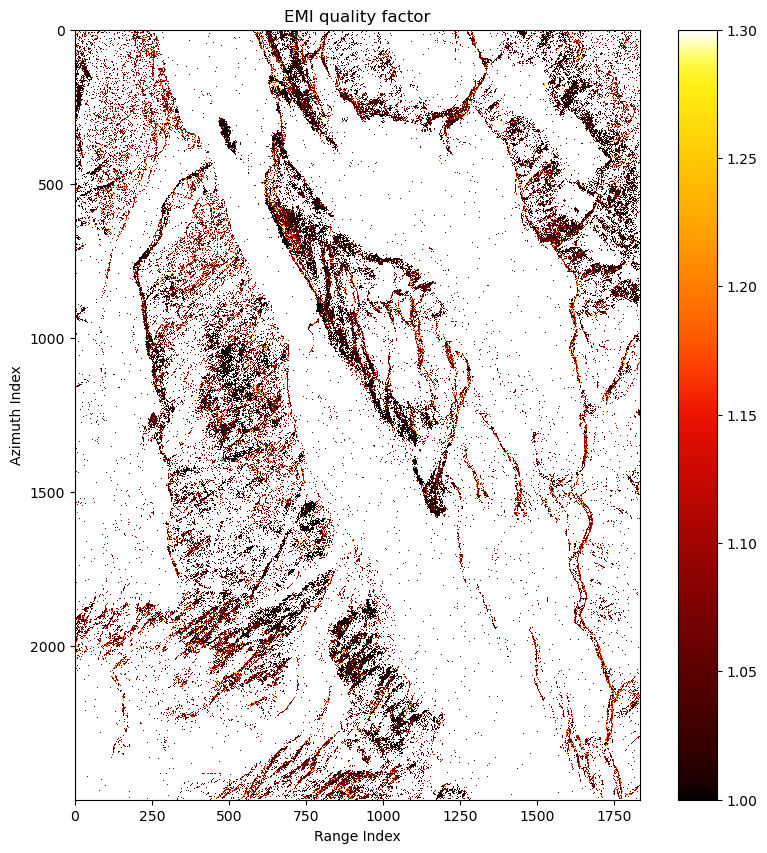

In [ ]:
emi_zarr = zarr.open('./pl/emi_quality.zarr','r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(emi_zarr[:],interpolation='nearest',vmin=1.0,vmax=1.3,cmap=colorcet.cm.fire)
ax.set(title='EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)

In [ ]:
!de_emi ./co/ds_can_coh.zarr ./pl/ds_can_ph.zarr ./pl/ds_can_emi_quality.zarr

2023-10-22 22:34:35 - de_emi - INFO - fetching args:
2023-10-22 22:34:35 - de_emi - INFO - coh = './co/ds_can_coh.zarr'
2023-10-22 22:34:35 - de_emi - INFO - ph = './pl/ds_can_ph.zarr'
2023-10-22 22:34:35 - de_emi - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2023-10-22 22:34:35 - de_emi - INFO - ref = 0
2023-10-22 22:34:35 - de_emi - INFO - n_pc_chunk = None
2023-10-22 22:34:35 - de_emi - INFO - pc_chunk_size = None
2023-10-22 22:34:35 - de_emi - INFO - log = None
2023-10-22 22:34:35 - de_emi - INFO - fetching args done.
2023-10-22 22:34:35 - de_emi - INFO - ./co/ds_can_coh.zarr zarray shape: (740397, 17, 17)
2023-10-22 22:34:35 - de_emi - INFO - ./co/ds_can_coh.zarr zarray chunks: (246799, 17, 17)
2023-10-22 22:34:35 - de_emi - INFO - ./co/ds_can_coh.zarr zarray dtype: complex64
2023-10-22 22:34:35 - de_emi - INFO - automatically determine pc_chunk_size from pc_chunk_size of coh.
2023-10-22 22:34:35 - de_emi - INFO - pc_chunk_size for ph: 246799
2023-10-22 22:34:35 - de_emi -

In [ ]:
#| export
@call_parse
@log_args
def de_ds_temp_coh(coh:str, # coherence matrix
                   ph:str, # wrapped phase
                   t_coh:str, # output, temporal coherence
                   n_pc_chunk:int=None, # number of point cloud chunk
                   pc_chunk_size:int=None, # point cloud chunk size
                   log:str=None, #log
                  ):
    '''DS temporal coherence.
    '''
    coh_path = coh
    ph_path = ph
    t_coh_path = t_coh

    logger = get_logger(logfile=log)
    coh_zarr = zarr.open(coh_path,mode='r'); logger.zarr_info(coh_path,coh_zarr)
    ph_zarr = zarr.open(ph_path,mode='r'); logger.zarr_info(ph_path,ph_zarr)

    pc_chunk_size = get_pc_chunk_size_from_pc_chunk_size('coh','ph',coh_zarr.chunks[0],coh_zarr.shape[0],logger,n_pc_chunk=n_pc_chunk,pc_chunk_size=pc_chunk_size)

    logger.info('starting dask CUDA local cluster.')
    with LocalCUDACluster(CUDA_VISIBLE_DEVICES=get_cuda_cluster_arg()['CUDA_VISIBLE_DEVICES']) as cluster, Client(cluster) as client:
        logger.info('dask local CUDA cluster started.')

        cpu_coh = da.from_zarr(coh_path, chunks=(pc_chunk_size,*coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)
        
        cpu_ph = da.from_zarr(ph_path, chunks=(pc_chunk_size,*ph_zarr.shape[1:]))
        logger.darr_info('ph', cpu_ph)

        logger.info(f'Estimate temporal coherence for DS.')
        coh = cpu_coh.map_blocks(cp.asarray)
        ph = cpu_ph.map_blocks(cp.asarray)

        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=(-2,-1))
        ph_delayed = ph.to_delayed()
        ph_delayed = np.squeeze(ph_delayed,axis=-1)
        t_coh_delayed = np.empty_like(coh_delayed,dtype=object)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                t_coh_delayed[idx] = delayed(ds_temp_coh,pure=True,nout=1)(coh_delayed[idx],ph_delayed[idx])
                t_coh_delayed[idx] = da.from_delayed(t_coh_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=cp.array((),dtype=cp.float32))

            t_coh = da.block(t_coh_delayed.tolist())
    
        cpu_t_coh = t_coh.map_blocks(cp.asnumpy)
        logger.info(f'got temporal coherence t_coh.')
        logger.darr_info('t_coh', t_coh)

        logger.info('saving t_coh.')
        _cpu_t_coh = cpu_t_coh.to_zarr(t_coh_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_cpu_t_coh)
        progress(futures,notebook=False)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function estimate the temporal coherence of DSs which is defined as [@ferrettiNewAlgorithmProcessing2011]:

$$\gamma = \frac{1}{N^2-N} \sum_{n=1}^{N} \sum_{k \neq n}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)}$$

Where $\phi_{nk}$ is the phase of complex coherence matrix and $\theta_{n}$ is the phase after phase linking.

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_t_coh = './pl/ds_can_t_coh.zarr'

In [ ]:
de_ds_temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh)

2023-10-22 23:37:53 - de_ds_temp_coh - INFO - fetching args:
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - coh = './co/ds_can_coh.zarr'
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ph = './pl/ds_can_ph.zarr'
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - t_coh = './pl/ds_can_t_coh.zarr'
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - n_pc_chunk = None
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - pc_chunk_size = None
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - log = None
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - fetching args done.
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ./co/ds_can_coh.zarr zarray shape: (740397, 17, 17)
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ./co/ds_can_coh.zarr zarray chunks: (246799, 17, 17)
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ./co/ds_can_coh.zarr zarray dtype: complex64
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ./pl/ds_can_ph.zarr zarray shape: (740397, 17)
2023-10-22 23:37:53 - de_ds_temp_coh - INFO - ./pl/ds_can_ph.zarr zarray chun

In [ ]:
ds_can_idx = './shp/ds_can_idx.zarr'
t_coh = './pl/t_coh.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/','r')
de_pc2ras(ds_can_idx, ds_can_t_coh,t_coh,rslc_zarr.shape[:2],az_chunk_size=rslc_zarr.chunks[0])

2023-10-22 23:42:11 - de_pc2ras - INFO - fetching args:
2023-10-22 23:42:11 - de_pc2ras - INFO - idx = './shp/ds_can_idx.zarr'
2023-10-22 23:42:11 - de_pc2ras - INFO - pc = './pl/ds_can_t_coh.zarr'
2023-10-22 23:42:11 - de_pc2ras - INFO - ras = './pl/t_coh.zarr'
2023-10-22 23:42:11 - de_pc2ras - INFO - shape = (2500, 1834)
2023-10-22 23:42:11 - de_pc2ras - INFO - az_chunk_size = 1000
2023-10-22 23:42:11 - de_pc2ras - INFO - n_az_chunk = None
2023-10-22 23:42:11 - de_pc2ras - INFO - log = None
2023-10-22 23:42:11 - de_pc2ras - INFO - fetching args done.
2023-10-22 23:42:11 - de_pc2ras - INFO - idx zarray shape: (2, 740397)
2023-10-22 23:42:11 - de_pc2ras - INFO - idx zarray chunks: (2, 246799)
2023-10-22 23:42:11 - de_pc2ras - INFO - idx zarray dtype: int32
2023-10-22 23:42:11 - de_pc2ras - INFO - got az_chunk_size for ras: 1000
2023-10-22 23:42:11 - de_pc2ras - INFO - loading idx into memory.
2023-10-22 23:42:11 - de_pc2ras - INFO - starting dask local cluster.
2023-10-22 23:42:19 - de

<matplotlib.colorbar.Colorbar>

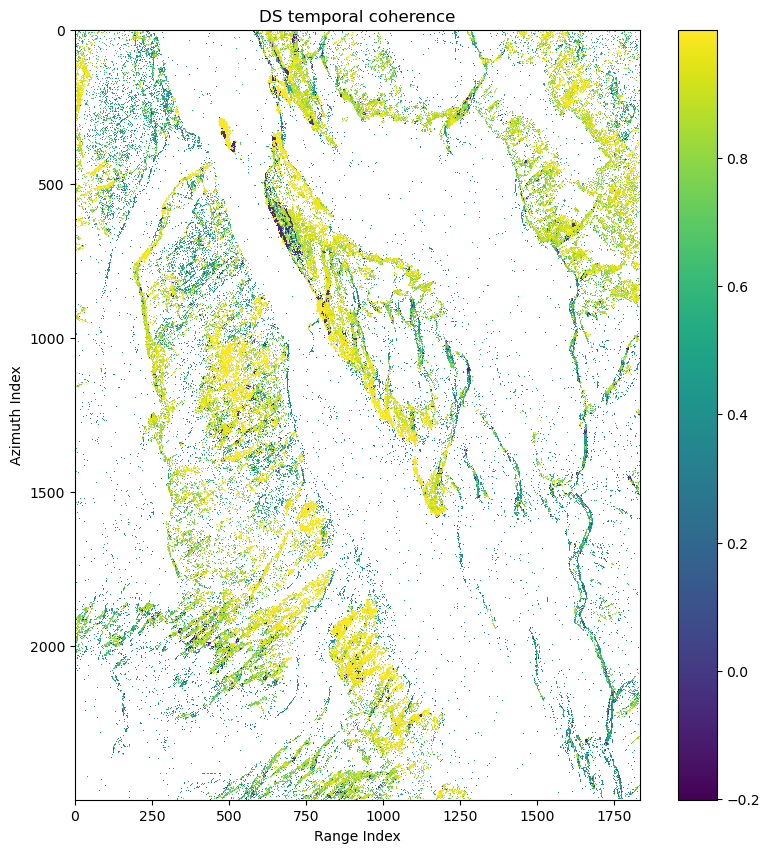

In [ ]:
t_coh_zarr = zarr.open(t_coh,'r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(t_coh_zarr[:],interpolation='nearest')
ax.set(title='DS temporal coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()